In [1]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from torch.autograd import Variable
import torch
import torch.optim as optim

from autograd.core import primitive
import tensorflow as tf
import math as mat

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import matplotlib.animation as animation
from itertools import count
from IPython import display
import random

In [3]:
nT = 40
dT = 1. / nT
# W = [npr.randn(1, 10), npr.randn(10, 1)]
T_space = Variable(torch.linspace(0, 1, nT),requires_grad=False) 

In [4]:
inf_s = 1e-3
y_0 = 1
k = 1
r_0 = 6
# l = 8.485*k
# e = 0.94
e = 0.9701
# l = 3.46
l = 3.75

# Sigmoid  activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# sigmoid derivative
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))


# tanh derivative
def tanh_grad(x):
    return 4/(torch.exp(x)+torch.exp(-x))**2

# tanh activation function
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))


# LeakyReLU activation
def leakyReLU(x):
  return torch.where(x > 0.0, x, x * 0.01)

# Leaky ReLU derivative
def leakyReLU_grad(x):
  return torch.where(x > 0.0, 1.0, 0.01)


# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and sigmoid activation
# def neural_network(W, x, b):
#      a1 = sigmoid(torch.mul(W[0],x) + b)
#      return torch.dot(torch.flatten(a1), torch.flatten(W[1]))


# This function takes the derivative of Neural Network output w.r.t 't'
# def d_neural_network_dx(W, x, k=1):
#     return (neural_network(W, x + inf_s) - neural_network(W, x))/inf_s

# derivative of NN analytical with sigmoid activation
# def d_neural_network_dx(W, x, b, k=1):
#     return torch.dot(torch.flatten(sigmoid_grad(torch.mul(W[0],x) + b)) , torch.flatten(torch.transpose(W[0],0,1).mul(W[1])))

# This function constructs a three layered neural network with 1 input layer and one output layer (ex: NN_x(t) and NN_y(t)) and tanh activation
def neural_network(W, x, b):
     a1 = tanh(torch.mul(W[0],x) + b)
     return torch.dot(torch.flatten(a1), torch.flatten(W[1]))


# derivative of NN analytical with tanh activation
def d_neural_network_dx(W, x, b, k=1):
    return torch.dot(torch.flatten(tanh_grad(torch.mul(W[0],x) + b)) , torch.flatten(torch.transpose(W[0],0,1).mul(W[1])))


# # neural network with ReLU activation
# def neural_network(W, x, b):
#      a1 = leakyReLU(torch.mul(W[0],x) + b)
#      return torch.dot(torch.flatten(a1), torch.flatten(W[1]))

# # neural network derivative with ReLU activation 
# def d_neural_network_dx(W, x, b, k=1):
#     return torch.dot(torch.flatten(leakyReLU_grad(torch.mul(W[0].float(),x.float()) + b.float())) , torch.flatten(torch.transpose(W[0].float(),0,1).mul(W[1].float())))



# def d_neural_network_dx(W, x, k=1):
#     return (neural_network(W, x + inf_s) - neural_network(W, x))/inf_s
#     # return np.dot(np.multiply(W[0][0], sigmoid_grad(np.dot(x, W[0][0]))), W[1])


# def dd_neural_network_dx(W_r, Ti, b, k=1):
#     return ((d_neural_network_dx(W_r, Ti+inf_s, b) - d_neural_network_dx(W_r, Ti))/inf_s)



In [9]:
# G*M/c**2 = 1

# def get_errSqr_t(t_T, d_t_T, r_T):
#     c = 1 - (k/r_0)
#     return (d_t_T - e/c)**2

def get_errSqr_t(r_T, t_T, d_t_T):
    c = 1 - (k/r_T)
    return (d_t_T - e/c)**2

def get_errSqr_r(r_T, d_r_T):
    a = (1+((l**2)/r_T**2))
    b = (1 - (k/r_T))
    return ((d_r_T)**2 - e**2 + a*b)**2

# def get_errSqr_fi(r_T,d_fi_T):
#     return (d_fi_T - l/(r_T**2))**2

# def get_errSqr_fi(r_T,d_fi_T):
#     return (d_fi_T - l/(r_0**2))**2

def get_errSqr_fi(r_T,d_fi_T):
    return (d_fi_T - l/(r_T**2))**2

In [6]:
def loss_function(W, T, epoch, b):
    loss_sum = 0.
    for Ti in T:
        W_t = W[0]
        W_r = W[1]
        W_fi = W[2]
        net_out_t = neural_network(W_t, Ti, b[0][0])
        net_out_r = neural_network(W_r, Ti, b[1][0])
        net_out_fi = neural_network(W_fi, Ti, b[2][0])
        # y_t = y_0 + (xi+1) * net_out
        t_T = Ti*net_out_t
        # r_T = r_0 + (Ti**2)*net_out_r
        r_T = r_0 + Ti*net_out_r
        fi_T = Ti*net_out_fi
        d_net_out_t = d_neural_network_dx(W_t, Ti, b[0][0])
        d_net_out_r = d_neural_network_dx(W_r, Ti, b[1][0])
        d_net_out_fi = d_neural_network_dx(W_fi, Ti, b[2][0])
        d_t_T = net_out_t + Ti*d_net_out_t
        # d_r_T = 2*Ti*net_out_r + (Ti**2)*d_net_out_r
        d_r_T = net_out_r + Ti*d_net_out_r
        d_fi_T = net_out_fi + Ti*d_net_out_fi
        # dd_net_out_r = dd_neural_network_dx(W_r, Ti, b[1][0])
        # dd_r_T = 2*net_out_r + (4*Ti)*d_net_out_r + (Ti**2)*dd_net_out_r
        # d_y_t = net_out + (xi+1)* d_net_out
        # func = f(xi, y_t)
        # Calculating errors individually from the three differential equations
        # err_sqr_t = get_errSqr_t(t_T, d_t_T, r_T)
        err_sqr_t = get_errSqr_t(r_T, t_T, d_t_T)
        err_sqr_r = get_errSqr_r(r_T, d_r_T)
        # err_sqr_fi = get_errSqr_fi(r_T,d_fi_T)
        err_sqr_fi = get_errSqr_fi(r_T, d_fi_T)
        err_sqr = err_sqr_t + err_sqr_fi + err_sqr_r
        # err_sqr = (d_y_t - func)**2
        loss_sum += err_sqr
    print("epoch-->>",epoch, loss_sum)
    return loss_sum

In [10]:
# Weights initialization for 1 hidden layered network for Neural net NN_x and NN_y
W_t = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))), requires_grad=True)]
b_t = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True)]
W_r = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))), requires_grad=True)]
b_r = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True)]
W_fi = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True), Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(20+1)), size = (20,1))), requires_grad=True)]
b_fi = [Variable(torch.from_numpy(np.random.normal(loc=0.0, scale = np.sqrt(2/(1+20)), size = (1,20))), requires_grad=True)]

# W = [W_t,W_r,W_fi]
# b = [b_t,b_r,b_fi]

W = [W_t,W_r,W_fi]
b = [b_t,b_r,b_fi]

# x = np.array(1)
# print neural_network(W, x)
# print d_neural_network_dx(W, x)

# optimizer = optim.Adam([W[0][0], W[0][1], W[1][0], W[1][1], W[2][0], W[2][1], b[0][0], b[1][0], b[2][0]], lr=0.000001)

optimizer = optim.Adam([W[0][0], W[0][1], W[1][0], W[1][1], W[2][0], W[2][1], b[0][0], b[1][0], b[2][0]], lr=0.001)

for i in range(500):
    
    optimizer.zero_grad()
    loss = loss_function(W, T_space, i, b)

    # This function will calculate the gradient of loss function w.r.t all the weights for which the requires_grad is set to true
    # and save the calculated gradient in w[i].grad.data where w[i] is the ith weight in the weight array 

    loss.backward()


    optimizer.step()
    # Setting the grad.data to zero before next iteration because otherwise it will add the grad to prev value
    W[0][0].grad.data.zero_()
    W[0][1].grad.data.zero_()
    W[1][0].grad.data.zero_()
    W[1][1].grad.data.zero_()
    W[2][0].grad.data.zero_()
    W[2][1].grad.data.zero_()
    b[0][0].grad.data.zero_()
    b[1][0].grad.data.zero_()
    b[2][0].grad.data.zero_()


epoch-->> 0 tensor(72.2140, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 1 tensor(69.9354, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 2 tensor(67.7206, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 3 tensor(65.5697, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 4 tensor(63.4827, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 5 tensor(61.4594, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 6 tensor(59.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 7 tensor(57.6025, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 8 tensor(55.7676, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 9 tensor(53.9941, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 10 tensor(52.2808, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 11 tensor(50.6267, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 12 tensor(49.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch-->> 13 tensor(47.4896, dtype=torch.float64

In [ ]:
# print loss_function(W, x_space)
# res = [y_0 + ((xi+1) * neural_network(W, xi)[0][0]) for xi in x_space]
res_t = [Ti*neural_network(W_t, Ti, b[0][0]) for Ti in T_space]
res_r = [r_0 + Ti*neural_network(W_r, Ti, b[1][0]) for Ti in T_space]
res_fi = [Ti*neural_network(W_fi, Ti, b[2][0]) for Ti in T_space]


In [ ]:
plt.plot(T_space, res_t)

6.0   -0.0
6.000044998668512   -0.09223424282516872
6.000089903607145   -0.1844525798329793
6.0001347148604225   -0.2766548218184255
6.000179432452407   -0.36884073668909895
6.000224056433578   -0.46101014596841544
6.000268586865033   -0.5531628925993263
6.00031302374611   -0.6452986909245478
6.000357367138679   -0.737417383901659
6.000401617104793   -0.829518814460891
6.000445773624621   -0.9216026541732224
6.0004898368225446   -1.013668874486859
6.000533806700016   -1.1057171898261577
6.0005776832592   -1.1977473146894557
6.000621466625042   -1.28975922044705
6.000665156800343   -1.381752621597183
6.00070875378861   -1.4737272327164634
6.000752257674922   -1.565682939554394
6.00079566858472   -1.6576197133291677
6.000838986401559   -1.7495370120658378
6.000882211251776   -1.8414348070423383
6.000925343181202   -1.9333128984577144
6.000968382316032   -2.0251712574343763
6.0010113285426465   -2.11700934234294
6.001054182067788   -2.208827295206777
6.001096942779252   -2.300624574578037

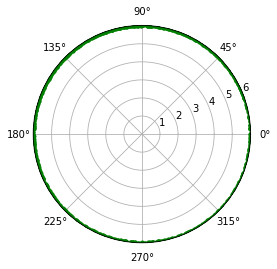

In [13]:
plt.axes(projection = 'polar')
  
# creating an array
# containing the radian values
# rads = np.arange(0, 2 * np.pi, 0.001) 
# Variable(torch.linspace(0, 1, nT),requires_grad=False) 
  
# plotting the spiral
nT_new = 1000
T_space_new = Variable(torch.linspace(0, 1, nT_new),requires_grad=False)
for Ti in T_space_new:
    # r = torch.sqrt(l/(neural_network(W_fi, Ti, b[1][0]) + Ti*d_neural_network_dx(W_fi, Ti, b[1][0])))
    r = r_0 + Ti*neural_network(W_r, Ti, b[1][0])
    r1 =  r.detach().numpy()
    # print(type(r1))
    fi_ti = Ti*neural_network(W_fi, Ti, b[1][0])
    fi_ti1 = fi_ti.detach().numpy()
    print(r1, " ", fi_ti1*200)
    # print(type(fi_ti1))
    plt.polar(fi_ti1*200, r1, 'g.')
      
# display the polar plot
plt.show()

0.0
0.005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5


0.505


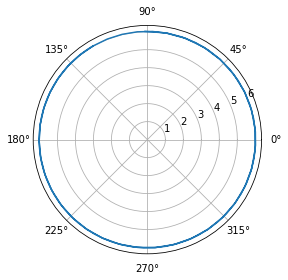

In [16]:
fi=[]
r=[]
i1 = count()
def animate1(j):
    t=next(i1)/200
    print(t)
    # theta.append(2*t)
    fi_ti = Ti*neural_network(W_fi, t, b[1][0])
    fi_ti_num = fi_ti.detach().numpy()
    fi_ti_num = fi_ti_num*200
    fi.append(fi_ti_num)
    r1 = r_0 + Ti*neural_network(W_r, Ti, b[1][0])
    r1_num =  r1.detach().numpy()
    r.append(r1_num)
    plt.cla()
    plt.subplot(111, projection='polar')
    plt.plot(fi, r)
animation_2 = animation.FuncAnimation(plt.gcf(),animate1,interval=100)
video_2 = animation_2.to_html5_video()
html_code_2 = display.HTML(video_2)
display.display(html_code_2)
plt.tight_layout()
plt.show()